In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator


%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv",index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
df_gender_sub = pd.read_csv("sampleSubmission.csv", index_col='id')

In [3]:
#Create variable for test data filled with nan
df_test["target"] = np.nan

In [4]:
df_train.shape

(11962, 231)

In [5]:
df_test.shape

(5121, 231)

In [6]:
df_all = pd.concat([df_train, df_test])
df_all.shape

(17083, 231)

In [7]:
df_all["target"].head()

id
1    0.0
2    0.0
3    0.0
4    1.0
6    0.0
Name: target, dtype: float64

In [8]:
df_all["target"].tail()

id
17074   NaN
17076   NaN
17079   NaN
17082   NaN
17083   NaN
Name: target, dtype: float64

In [9]:
cat_obs = df_all.select_dtypes(include = ['object'].copy())
# converting to categorical data for faster computing purposes 
for i in cat_obs:
    cat_obs[i] = cat_obs[i].astype('category')

In [10]:
vars_all = df_all.columns.values
var_dep = ['target']



vars_ind = [var for var in vars_all if var not in (var_dep)]

In [11]:
vars_ind_numeric = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes != 'object'])
vars_ind_categorical = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes == 'object'])

In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16 LTS; OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS); OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /anaconda3/envs/deep_learning/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpisswu3fb
  JVM stdout: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpisswu3fb/h2o_gunnarwindsand_started_from_python.out
  JVM stderr: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpisswu3fb/h2o_gunnarwindsand_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_gunnarwindsand_1azkcz
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [162]:
h2o.remove_all() 

In [13]:
h2o_df_all = h2o.H2OFrame(df_all[vars_ind + var_dep])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
# To use for predictions
h2o_train = h2o.import_file("train.csv")
h2o_test = h2o.import_file("test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
y = "target"
x = h2o_df_all.names 
x.remove(y)

In [16]:
train, valid, test = h2o_df_all.split_frame([0.75, 0.15 ])

In [17]:
train["target"] = train["target"].asfactor()
valid["target"] = valid["target"].asfactor()
test["target"] = test["target"].asfactor()

In [18]:
glm_1 = H2OGeneralizedLinearEstimator(alpha=1,
                                     family="binomial",
                                      standardize = True,
                                     link="logit",
                                     lambda_search=True,
                                     seed=2000000)

In [19]:
glm_1.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
glm_1.model_performance(train).auc()

0.8752790111836225

In [29]:
# fréature 
glm_1.model_performance(test).auc()
glm_1.model_performance(train).auc()
glm_1.accuracy()
glm_1.confusion_matrix()

0.8292279110957098

In [28]:
# fréature 
glm_1.accuracy()

[[0.4159559226449708, 0.9262004868333702]]

In [30]:
glm_1.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22158264574177716: 


,0,1,Error,Rate
0,7724.0,495.0,0.0602,(495.0/8219.0)
1,373.0,446.0,0.4554,(373.0/819.0)
Total,8097.0,941.0,0.096,(868.0/9038.0)


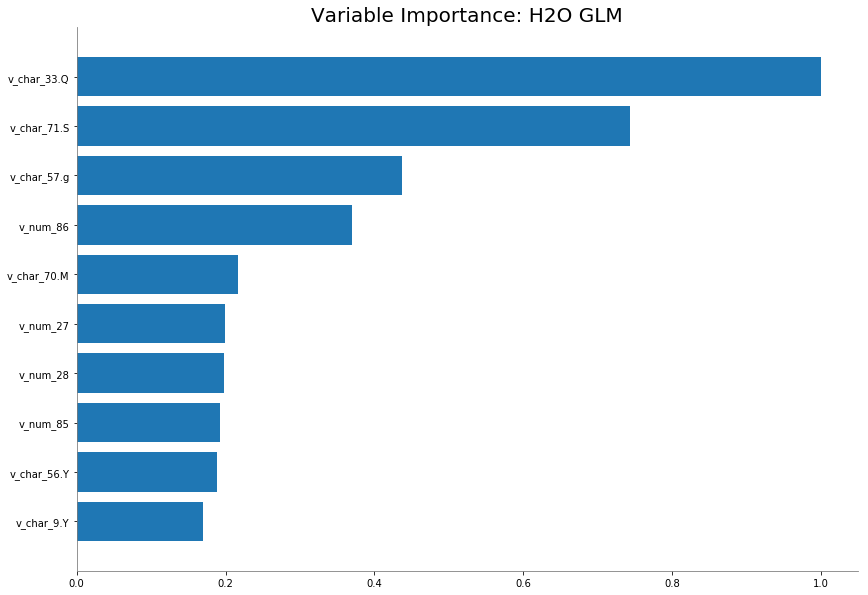

In [31]:
glm_1.varimp_plot()

In [32]:
df_coef= pd.Series(glm_1.coef())
df_coef= df_coef[np.abs(df_coef) > 0]
df_coef.head()

Intercept      -4.768491
v_char_100.q    0.232808
v_char_43.T    -0.041053
v_char_43.f     0.266351
v_char_118.P    0.082253
dtype: float64

In [33]:
df_coef.shape

(118,)

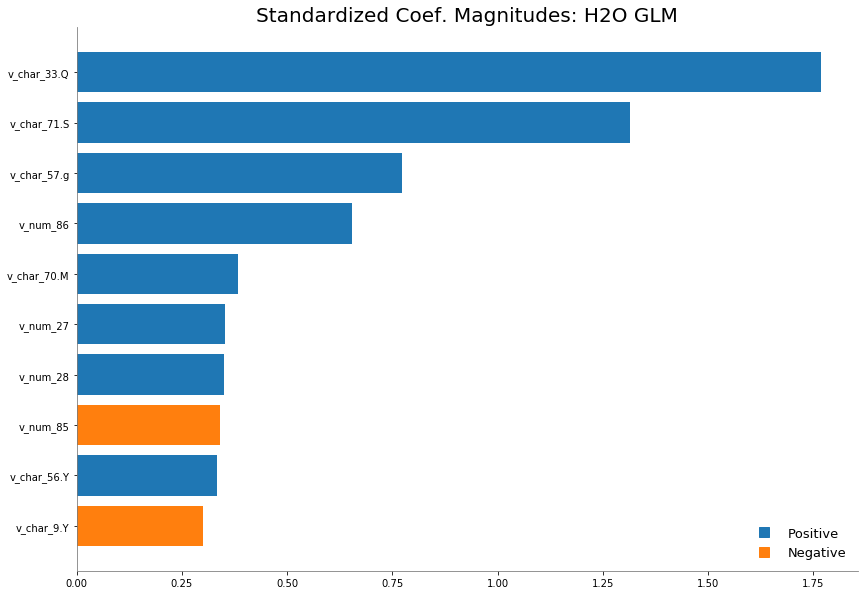

In [34]:
glm_1.std_coef_plot(num_of_features=10)

In [35]:
glm_perf1 = glm_1.model_performance(test)

In [36]:
# Retreive test set AUC
print(glm_perf1.gini())

0.6584558221914196


In [37]:
# Compare test AUC to the training AUC and validation AUC
print (glm_1.gini(train=True))

0.750558022367245


In [38]:
predictions = glm_1.predict(test_data=h2o_test)
#pred = predictions.concat(h2o_test["id"])
#pred.head(5)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [39]:
submission = pd.read_csv('sampleSubmission.csv')
# Using fraud as indicator
submission['target'] = predictions['p1'].as_data_frame()

In [40]:
submission.head()

,id,target
0,5,0.056435
1,10,0.170487
2,11,0.020365
3,13,0.193980
4,16,0.015281


In [174]:
submission.to_csv('glm_20_submission.csv', index = False)
submission.head()

,id,target
0,5,0.064768
1,10,0.162993
2,11,0.033675
3,13,0.150590
4,16,0.017898


## Random Forest

In [41]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1',   seed=1)

In [42]:
rf_fit1.train(x=x, y=y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [43]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100,   seed=1)
rf_fit2.train(x=x, y=y, training_frame=train,validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [45]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)
# Retreive test set AUC
print(rf_perf1.gini())
print(rf_perf2.gini())

0.6857835917872304
0.6892103920606043


In [46]:
print(rf_fit2.model_performance(test).auc())
print(rf_fit2.model_performance(train).auc())
print(rf_fit2.accuracy())
print(rf_fit2.confusion_matrix())

0.8446051960303022
1.0
[[0.4586909895053702, 0.9213321531312237]]
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23787546832781664: 


,0,1,Error,Rate
0,7687.0,532.0,0.0647,(532.0/8219.0)
1,404.0,415.0,0.4933,(404.0/819.0)
Total,8091.0,947.0,0.1036,(936.0/9038.0)


In [57]:
# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=50,                      # Up to 500 decision trees in the forest 
    max_depth=30,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration=True,       # score validation error on every iteration/new tree
    model_id='rf_model',             # for easy lookup in flow
    seed=12345)                      

# train rf model
rf_model.train(
    x=x,
    y=y,
    training_frame=train,
    validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [58]:
# measure rf AUC
print(rf_model.auc(train=True))
print(rf_model.auc(valid=True))
print(rf_model.model_performance(test_data=test).auc())

0.8079799166914389
0.847049551220236
0.8414767969043287


In [59]:
rf_model.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2692307692307693: 


,0,1,Error,Rate
0,7781.0,438.0,0.0533,(438.0/8219.0)
1,469.0,350.0,0.5726,(469.0/819.0)
Total,8250.0,788.0,0.1004,(907.0/9038.0)


In [47]:
# Import H2O Grid Search:
from h2o.grid.grid_search import H2OGridSearch

# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [48]:
# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.01, 0.1], 
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

In [49]:
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=x, y=y, 
                training_frame=train, 
                validation_frame=valid, 
                ntrees=100,
                seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [52]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
best1 = gbm_gridperf1[0]

In [54]:
gbm_perf1 = best1.model_performance(test)
gbm_perf2 = best1.model_performance(test)
# Retreive test set AUC
print(gbm_perf1.gini())
print(gbm_perf2.gini())

0.7311790695659706
0.7311790695659706



### Random Grid Search
This example is set to run fairly quickly -- increase max_runtime_secs or max_models to cover more of the hyperparameter space. Also, you can expand the hyperparameter space of each of the algorithms by modifying the hyper parameter list below.
In addition to the hyperparameter dictionary, we will specify the search_criteria as 'RandomDiscrete', with a max numeber of models equal to 36.

In [60]:
# GBM hyperparameters
gbm_params2 = {'learn_rate': [i * 0.01 for i in range(1, 11)], 
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria2 = {'strategy': 'RandomDiscrete', 'max_models': 36}

In [61]:
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params2,
                          search_criteria=search_criteria2)
gbm_grid2.train(x=x, y=y, 
                training_frame=train, 
                validation_frame=valid, 
                ntrees=100,
                seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [63]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)
best2 = gbm_gridperf2[0]

In [64]:
best2.accuracy()

[[0.2057634900066371, 0.9675813233016154]]

In [69]:
best2.model_performance(train)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.04770889981103608
RMSE: 0.21842367044584723
LogLoss: 0.17867677070183502
Mean Per-Class Error: 0.10356538595983789
AUC: 0.9665611456583595
pr_auc: 0.8596851719217736
Gini: 0.933122291316719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1987598916426681: 


,0,1,Error,Rate
0,8149.0,70.0,0.0085,(70.0/8219.0)
1,226.0,593.0,0.2759,(226.0/819.0)
Total,8375.0,663.0,0.0328,(296.0/9038.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1987599,0.8002699,182.0
max f2,0.1663522,0.7724477,201.0
max f0point5,0.2571066,0.8857809,157.0
max accuracy,0.2076505,0.9675813,177.0
max precision,0.6863604,1.0,0.0
max recall,0.0521441,1.0,359.0
max specificity,0.6863604,1.0,0.0
max absolute_mcc,0.2076505,0.7889641,177.0
max min_per_class_accuracy,0.0979139,0.8913309,263.0
max mean_per_class_accuracy,0.0918658,0.8964346,271.0


Gains/Lift Table: Avg response rate:  9.06 %, avg score:  9.05 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0123921,0.5490279,11.0354090,11.0354090,1.0,0.6039644,1.0,0.6039644,0.1367521,0.1367521,1003.5409035,1003.5409035
,2,0.0241204,0.4653945,11.0354090,11.0354090,1.0,0.5035575,1.0,0.5551427,0.1294261,0.2661783,1003.5409035,1003.5409035
,3,0.0356274,0.3962288,11.0354090,11.0354090,1.0,0.4291789,1.0,0.5144588,0.1269841,0.3931624,1003.5409035,1003.5409035
,4,0.0454747,0.3398111,10.7874223,10.9817087,0.9775281,0.3682545,0.9951338,0.4827990,0.1062271,0.4993895,978.7422316,998.1708748
,5,0.0559858,0.2820937,10.1061114,10.8173179,0.9157895,0.3110040,0.9802372,0.4505450,0.1062271,0.6056166,910.6111432,981.7317948
,6,0.0972560,0.1488534,4.2603188,8.0348826,0.3860590,0.1984036,0.7281001,0.3435498,0.1758242,0.7814408,326.0318770,703.4882574
,7,0.1453861,0.1094110,1.4713879,5.8620362,0.1333333,0.1259951,0.5312024,0.2715283,0.0708181,0.8522589,47.1387871,486.2036154
,8,0.1949546,0.0918651,1.3055283,4.7035143,0.1183036,0.0997596,0.4262202,0.2278550,0.0647131,0.9169719,30.5528301,370.3514294
,9,0.2947555,0.0747312,0.4526720,3.2642276,0.0410200,0.0818274,0.2957958,0.1784117,0.0451770,0.9621490,-54.7328011,226.4227598
,10,0.3957734,0.0658382,0.1329567,2.4649963,0.0120482,0.0697887,0.2233715,0.1506866,0.0134310,0.9755800,-86.7043265,146.4996315


In [65]:
best2.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2039585391862765: 


,0,1,Error,Rate
0,8154.0,65.0,0.0079,(65.0/8219.0)
1,229.0,590.0,0.2796,(229.0/819.0)
Total,8383.0,655.0,0.0325,(294.0/9038.0)


In [70]:
# GBM hyperparameters
gbm_params = {'learn_rate': [i * 0.01 for i in range(1, 31)],  #updated
                'max_depth': list(range(2, 11)),
                'sample_rate': [0.9, 0.95, 1.0],  #updated
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 60}  #updated

In [71]:
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
                         grid_id='gbm_grid2',
                         hyper_params=gbm_params,
                         search_criteria=search_criteria)
gbm_grid.train(x=x, y=y, 
               training_frame=train, 
               validation_frame=valid, 
               ntrees=100,
               seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [74]:
gbm_gridperf = gbm_grid.get_grid(sort_by='auc', decreasing=True)
best3 = gbm_gridperf[0]

In [75]:
best3.accuracy()

[[0.2057634900066371, 0.9675813233016154]]

In [76]:
best3.model_performance(train)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.04770889981103608
RMSE: 0.21842367044584723
LogLoss: 0.17867677070183502
Mean Per-Class Error: 0.10356538595983789
AUC: 0.9665611456583595
pr_auc: 0.8596851719217736
Gini: 0.933122291316719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1987598916426681: 


,0,1,Error,Rate
0,8149.0,70.0,0.0085,(70.0/8219.0)
1,226.0,593.0,0.2759,(226.0/819.0)
Total,8375.0,663.0,0.0328,(296.0/9038.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1987599,0.8002699,182.0
max f2,0.1663522,0.7724477,201.0
max f0point5,0.2571066,0.8857809,157.0
max accuracy,0.2076505,0.9675813,177.0
max precision,0.6863604,1.0,0.0
max recall,0.0521441,1.0,359.0
max specificity,0.6863604,1.0,0.0
max absolute_mcc,0.2076505,0.7889641,177.0
max min_per_class_accuracy,0.0979139,0.8913309,263.0
max mean_per_class_accuracy,0.0918658,0.8964346,271.0


Gains/Lift Table: Avg response rate:  9.06 %, avg score:  9.05 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0123921,0.5490279,11.0354090,11.0354090,1.0,0.6039644,1.0,0.6039644,0.1367521,0.1367521,1003.5409035,1003.5409035
,2,0.0241204,0.4653945,11.0354090,11.0354090,1.0,0.5035575,1.0,0.5551427,0.1294261,0.2661783,1003.5409035,1003.5409035
,3,0.0356274,0.3962288,11.0354090,11.0354090,1.0,0.4291789,1.0,0.5144588,0.1269841,0.3931624,1003.5409035,1003.5409035
,4,0.0454747,0.3398111,10.7874223,10.9817087,0.9775281,0.3682545,0.9951338,0.4827990,0.1062271,0.4993895,978.7422316,998.1708748
,5,0.0559858,0.2820937,10.1061114,10.8173179,0.9157895,0.3110040,0.9802372,0.4505450,0.1062271,0.6056166,910.6111432,981.7317948
,6,0.0972560,0.1488534,4.2603188,8.0348826,0.3860590,0.1984036,0.7281001,0.3435498,0.1758242,0.7814408,326.0318770,703.4882574
,7,0.1453861,0.1094110,1.4713879,5.8620362,0.1333333,0.1259951,0.5312024,0.2715283,0.0708181,0.8522589,47.1387871,486.2036154
,8,0.1949546,0.0918651,1.3055283,4.7035143,0.1183036,0.0997596,0.4262202,0.2278550,0.0647131,0.9169719,30.5528301,370.3514294
,9,0.2947555,0.0747312,0.4526720,3.2642276,0.0410200,0.0818274,0.2957958,0.1784117,0.0451770,0.9621490,-54.7328011,226.4227598
,10,0.3957734,0.0658382,0.1329567,2.4649963,0.0120482,0.0697887,0.2233715,0.1506866,0.0134310,0.9755800,-86.7043265,146.4996315


In [77]:
best3.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2039585391862765: 


,0,1,Error,Rate
0,8154.0,65.0,0.0079,(65.0/8219.0)
1,229.0,590.0,0.2796,(229.0/819.0)
Total,8383.0,655.0,0.0325,(294.0/9038.0)


In [175]:
h2o.cluster().shutdown()

H2O session _sid_a8e6 closed.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os, gc

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv",index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
df_gender_sub = pd.read_csv("sampleSubmission.csv", index_col='id')

In [3]:
#Create variable for test data filled with nan
df_test["target"] = np.nan

df_all = pd.concat([df_train, df_test])
df_all.shape

(17083, 231)

In [4]:
cat_obs = df_all.select_dtypes(include = ['object'].copy())
# converting to categorical data for faster computing purposes 
for i in cat_obs:
    cat_obs[i] = cat_obs[i].astype('category')
    
    
vars_all = df_all.columns.values
var_dep = ['target']

vars_ind = [var for var in vars_all if var not in (var_dep)]
vars_ind_numeric = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes != 'object'])
vars_ind_categorical = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes == 'object'])

In [5]:
h2o.init()
h2o.remove_all() 

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16 LTS; OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS); OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /anaconda3/envs/deep_learning/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpj3mwmzn1
  JVM stdout: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpj3mwmzn1/h2o_gunnarwindsand_started_from_python.out
  JVM stderr: /var/folders/k7/m7h3wyzn4yb714dfsnq0ysx00000gn/T/tmpj3mwmzn1/h2o_gunnarwindsand_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_gunnarwindsand_ocznra
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [6]:
h2o_df_all = h2o.H2OFrame(df_all[vars_ind + var_dep])
# To use for predictions
h2o_train = h2o.import_file("train.csv")
h2o_test = h2o.import_file("test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
y = "target"
x = h2o_df_all.names 
x.remove(y)


train, valid, test = h2o_df_all.split_frame([0.75, 0.15 ])

In [8]:
train["target"] = train["target"].asfactor()
valid["target"] = valid["target"].asfactor()
test["target"] = test["target"].asfactor()

In [ ]:
### RF1

In [19]:
param = {
      "ntrees" : 200
    , "max_depth" : 20
    #Row sample rate per tree (from 0.0 to 1.0). (default: ``0.6320000291``)
    , "sample_rate" : 0.7
    #col_sample_rate_per_tree: column sampling rate for each tree (without replacement)
    , "col_sample_rate_per_tree" : 0.9
    #mtries is applied AFTER col_sample_rate_per_tree
    , "mtries" : -1
    , "min_rows" : 10
    # beware of default min split improvement if using imbalanced classes
    #, min_split_improvement
    , "seed": 1
    , "score_each_iteration": True
    , "score_tree_interval": 1
    , "stopping_metric": 'AUC'
    , "stopping_rounds": 20
}

In [20]:
rf1 = H2ORandomForestEstimator(**param)
rf1.train(x=x, 
            y=y,
            training_frame=train,
            validation_frame=valid
            )

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
# measure rf AUC
print(rf1.auc(train=True))
print(rf1.auc(valid=True))
print(rf1.model_performance(test_data=test).auc())

0.8517082109596605
0.8448840965228958
0.8801177082037054


In [31]:
rf1.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20519105253197356: 


,0,1,Error,Rate
0,7602.0,483.0,0.0597,(483.0/8085.0)
1,399.0,414.0,0.4908,(399.0/813.0)
Total,8001.0,897.0,0.0991,(882.0/8898.0)


In [ ]:
### rf2

In [28]:
# initialize rf model
rf2 = H2ORandomForestEstimator(
    ntrees=200,                      # Up to 500 decision trees in the forest 
    max_depth=30,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration=True,       # score validation error on every iteration/new tree
    model_id='rf2',             # for easy lookup in flow
    seed=1)                      

# train rf model
rf2.train(
    x=x,
    y=y,
    training_frame=train,
    validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
# measure rf AUC
print(rf2.auc(train=True))
print(rf2.auc(valid=True))
print(rf2.model_performance(test_data=test).auc())

0.8236034568137889
0.8067186807270885
0.8698402008652432


In [49]:
n_models=8
hyper_params = {
    'max_depth':[4,8,16,24, 30],
    'ntrees':[50, 250, 1000],
    "min_rows" :[2, 5, 10, 20, 40],
    "col_sample_rate_per_tree" : [0.1, 0.2, 0.4, 0.6, 0.8, 0.9],
    "sample_rate" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "stopping_metric" : "AUC",
    "seed" : 1,
    "stopping_rounds" : 25
}


In [50]:
rf3 = H2OGridSearch(model=h2o.estimators.H2ORandomForestEstimator,
                     grid_id='rf3',
                     hyper_params=hyper_params,
                     search_criteria={'strategy': 'RandomDiscrete', 'max_models': n_models})

In [51]:
#Train grid search
rf3.train(x=x, 
           y=y,
           training_frame=train,
           validation_frame=valid)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate_per_tree, 0.9
Hyper-parameter: max_depth, 16
Hyper-parameter: min_rows, 10.0
Hyper-parameter: ntrees, 1000
Hyper-parameter: sample_rate, 0.9
Hyper-parameter: seed, 1
Hyper-parameter: stopping_metric, AUC
Hyper-parameter: stopping_rounds, 25
failure_details: None
failure_stack_traces: water.Job$JobCancelledException
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:450)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:360)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)
	at hex.ModelBuilder.trainModelNested(ModelBuilder.java:348)
	at hex.ModelBuilder$TrainModelNestedRunnable.run(ModelBuilder.java:383)
	at water.H2O.runOnH2ONode(H2O.java:1304)
	at water.H2O.runOnH2ONode(H2O.java:1297)
	at hex.ModelBuilder.trainModelNested(ModelBuilder.java:364)
	at hex.grid.GridSearch.buildModel(GridSearch.java:3

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [ ]:
grids_rf = rf3.get_grid(sort_by='auc', decreasing=True)
best_model_rf = grids_rf.models[0] # will be the best model from grid seach sorted by AUC
for par in grid_params:
    if par in best_model_gbm.params:
        print('par: ' + par); print(best_model_gbm.params[par])